# Classifier Comparison and Aggregate Taxonomic Results

Visualizes taxonomic similarity and overlap in classifier hits, then combines results into a final taxonomic description.

### Workflow:
- Visualize and quantify classifier overlap
- Aggregate unique and unanimously classified reads
- Visualize aggregated taxonomic result
***

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import (TextArea, DrawingArea,
                                   HPacker, VPacker, AnchoredOffsetbox)
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

from src import taxo_utils

## Data Preprocessing

In [2]:
cf_gtdb_path = r'raw_data\read_ids\cf_gtdb_id_name.tsv'
cf_nt_path = r'raw_data\read_ids\cf_nt_id_name.tsv'
cf_rs_path = r'raw_data\read_ids\cf_rs_id_name.tsv'
dmd_ur_path = r'raw_data\read_ids\dmd_ur_id_name.tsv'
dmd_nr_path = r'raw_data\read_ids\dmd_nr_id_name.tsv'
k2_rs_path = r'raw_data\read_ids\k2_rs_id_name.tsv'

In [3]:
paths_list = [('cf_gtdb', cf_gtdb_path),
              ('cf_nt', cf_nt_path),
              ('cf_rs', cf_rs_path),
              ('k2_rs', k2_rs_path),
              ('dmd_ur', dmd_ur_path),
              ('dmd_nr', dmd_nr_path)]

# Create read ID sets and mapping of read IDs to species names for each classifier

id_sets = {}
id_species_mapping = {}

for name, path in paths_list:
    temp = set()
    df = pd.read_csv(path, sep=r'\t|\s\s+', engine='python', header=0)
    ids = df['query_id'].tolist()
    temp = set(ids)
    id_species_mapping[name] = df.set_index('query_id')['species_name'].to_dict()
    id_sets[name] = temp

In [4]:
# resolve discrepancy in species naming between databases
for classifier, mapping in id_species_mapping.items():
    for qid, species in mapping.items():
        if species == 'Stutzerimonas kunmingensis':
            mapping[qid] = 'Stutzerimonas chloritidismutans'

In [5]:
combined_ids = id_sets['cf_gtdb'] | id_sets['cf_nt'] | id_sets['cf_rs'] | id_sets['k2_rs'] | id_sets['dmd_ur'] | id_sets['dmd_nr']
print('Total number classified:', len(combined_ids))

Total number classified: 1256863


## Visualization

In [6]:
id_to_cats = taxo_utils.plot_sankey(id_sets)

In [7]:
multi_mapping_ids = []
for _id, cats in id_to_cats.items():
    if len(cats) > 1:
        multi_mapping_ids.append(_id)

print(len(multi_mapping_ids), 'queries map to multiple classifiers')

480555 queries map to multiple classifiers


In [8]:
# Calculate pairwise species agreement between classifiers, stored in species_paired_counts

species_paired_counts = {}
unanimous_species_ids = set()
mixed_agreement_species_ids = set()
total_disagreement_species_ids = set()

for id_value in multi_mapping_ids:
    groups = id_to_cats[id_value]
    
    if len(groups) < 2:
        continue
    
    species_classifications = {(id_species_mapping[group][id_value]) for group in groups}
    
    if len(species_classifications) == 1:
        unanimous_species_ids.add(id_value)
    elif len(species_classifications) == len(groups):
        total_disagreement_species_ids.add(id_value)
    else:
        mixed_agreement_species_ids.add(id_value)

    groups_l = sorted(list(groups))
    for i in range(len(groups_l) - 1):
        for j in range(i + 1, len(groups_l)):
            group_key = f'{groups_l[i]},{groups_l[j]}'
            count = species_paired_counts.get(group_key, (0, 0))
            
            species1 = id_species_mapping[groups_l[i]][id_value]
            species2 = id_species_mapping[groups_l[j]][id_value]
            
            if species1 == species2:
                species_paired_counts[group_key] = (count[0] + 1, count[1])
            else:
                species_paired_counts[group_key] = (count[0], count[1] + 1)

In [9]:
# Calculate pairwise species agreement between classifiers, stored in genus_paired_counts

genus_paired_counts = {}
unanimous_genus_ids = set()
mixed_agreement_ids = set()
total_disagreement_ids = set()

for id_value in multi_mapping_ids:
    groups = id_to_cats[id_value]
    
    if len(groups) < 2:
        continue

    genus_classifications = {id_species_mapping[group][id_value].split(' ')[0] for group in groups}
    
    if len(genus_classifications) == 1:
        unanimous_genus_ids.add(id_value)
    elif len(genus_classifications) == len(groups):
        total_disagreement_ids.add(id_value)
    else:
        mixed_agreement_ids.add(id_value)

    groups_l = sorted(list(groups))
    for i in range(len(groups_l) - 1):
        for j in range(i + 1, len(groups_l)):
            group_key = f'{groups_l[i]},{groups_l[j]}'
            count = genus_paired_counts.get(group_key, (0, 0))
            
            genus1 = id_species_mapping[groups_l[i]][id_value].split(' ')[0]
            genus2 = id_species_mapping[groups_l[j]][id_value].split(' ')[0]
            
            if genus1 == genus2:
                genus_paired_counts[group_key] = (count[0] + 1, count[1])
            else:
                genus_paired_counts[group_key] = (count[0], count[1] + 1)

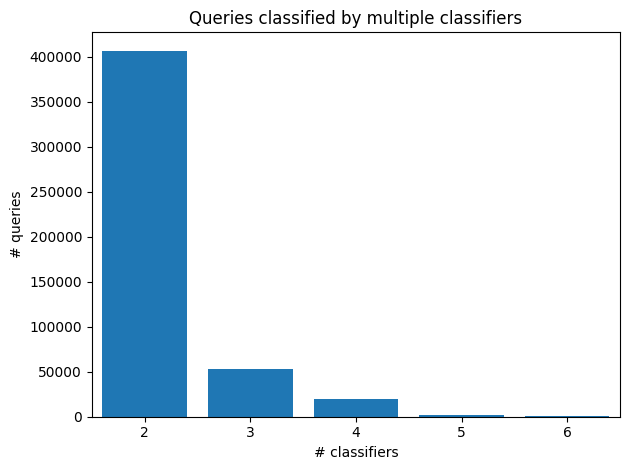

In [10]:
#Plot statistics for multiple mapped queries

total_counts = {}
for q in multi_mapping_ids:
    cats_for_q = id_to_cats[q]
    if len(cats_for_q) > 1:
        n = len(cats_for_q)
        total_counts[n] = total_counts.get(n, 0) + 1

x_total = sorted(total_counts.keys())
y_total = [total_counts[k] for k in x_total]

plt.figure()
plt.bar(x_total, y_total)
plt.xlabel('# classifiers')
plt.ylabel('# queries')
plt.xlim([min(x_total) - 0.5, max(x_total) + 0.5])
plt.xticks(x_total)
plt.title('Queries classified by multiple classifiers')
plt.tight_layout()
plt.savefig(r'figures/classifier_comp/multiple_numqueries.png')
plt.show()

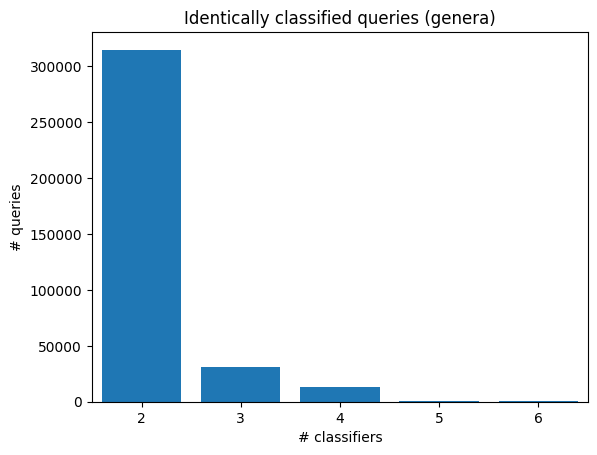

In [11]:
#Plot statistics for identically classified queries

ident_map_counts = {}
for q in multi_mapping_ids:
    cats_for_q = id_to_cats[q]
    if len(cats_for_q) > 1 and len({id_species_mapping[cat][q][0] for cat in cats_for_q}) == 1:
        n = len(cats_for_q)
        ident_map_counts[n] = ident_map_counts.get(n, 0) + 1

x_ident = sorted(ident_map_counts.keys())
y_ident = [ident_map_counts[k] for k in x_ident]

plt.figure()
plt.bar(x_ident, y_ident)
plt.xlabel('# classifiers')
plt.ylabel('# queries')
plt.xlim([min(x_ident) - 0.5, max(x_ident) + 0.5])
plt.xticks(x_ident)
plt.title('Identically classified queries (genera)')
plt.savefig(r'figures/classifier_comp/identical_numqueries.png')
plt.show()

C:\Users\yoche\AppData\Local\Temp\ipykernel_30824\3429398568.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



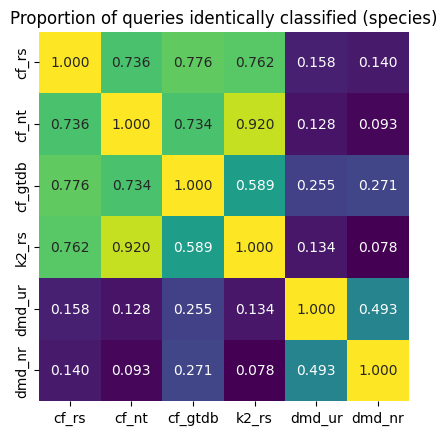

C:\Users\yoche\AppData\Local\Temp\ipykernel_30824\3429398568.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



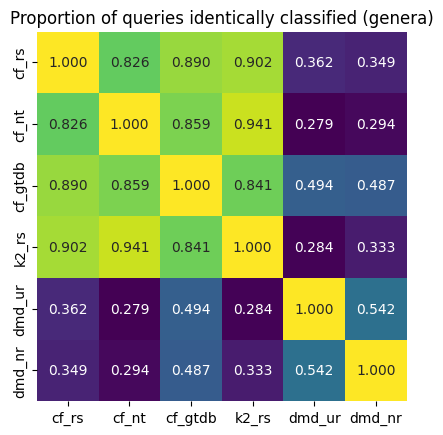

In [12]:
# Visualize pairwise classifier agreement
cats = ['cf_rs', 'cf_nt', 'cf_gtdb', 'k2_rs', 'dmd_ur', 'dmd_nr']

for counts, name in [(species_paired_counts, 'species'), (genus_paired_counts, 'genera')]:
    df = pd.DataFrame(0.0, index=cats, columns=cats)

    for key, (num, denom) in counts.items():
        a, b = key.split(',')
        if a in cats and b in cats:
            total = num + denom
            prop = num / total if total > 0 else 0.0
            df.loc[a, b] = prop
            df.loc[b, a] = prop
    
    for cat in cats:
        df.loc[cat, cat] = 1.0

    min_nonzero = df[df > 0].stack().min()
    tick_vals = np.around(np.linspace(0, df.values.max(), 15), 3)

    cmap = cm.get_cmap('viridis').copy()

    sns.heatmap(df, cmap=cmap,  annot=True, fmt='.3f', cbar = False, square = True, cbar_kws={'ticks': tick_vals})
    plt.title(f'Proportion of queries identically classified ({name})')
    plt.savefig(rf'figures\classifier_comp\identically_classified_{name}.png')
    plt.show()

In [13]:
#aggregate counts for all species that are either unanimously classified or uniquely classified
updated_spct = {}
for id in id_to_cats:
    idset = id_to_cats[id]
    if len(idset) == 1:
        dsname = next(iter(idset))
        spnm = id_species_mapping[dsname][id]
        updated_spct[spnm] = updated_spct.get(spnm, 0) + 1
    elif id in unanimous_species_ids:
        dsname = next(iter(idset))
        spnm = id_species_mapping[dsname][id]
        updated_spct[spnm] = updated_spct.get(spnm, 0) + 1
    else:
        continue

print(updated_spct)

spct_df = pd.DataFrame.from_dict(updated_spct, orient='index', columns=['count'])
spct_df['proportion'] = spct_df['count'] / spct_df['count'].sum()
spct_df = spct_df.sort_values(by='proportion', ascending=False)
spct_df = spct_df.dropna(axis='index')
print(spct_df.head())        

{'Halomonas halocynthiae': 182, 'Ichthyobacterium seriolicida': 38, 'Phenylobacterium zucineum': 8406, 'Pectobacterium actinidiae': 236, 'Stutzerimonas frequens': 1805, 'Brevundimonas fluminis': 11688, 'Stutzerimonas stutzeri': 684172, 'Acidovorax temperans': 11067, 'Sphingomonas koreensis': 5805, 'Geopseudomonas guangdongensis': 1490, 'Stutzerimonas chloritidismutans': 14679, 'Alternaria dauci': 150, 'Metapseudomonas furukawaii': 130, 'Alkalibacterium indicireducens': 1, 'Parasulfuritortus cantonensis': 5, 'Sphingopyxis italica': 8, 'Arenicella xantha': 11, 'Phosphitispora fastidiosa': 271, 'Neptunomonas phycophila': 2, 'Tissierella pigra': 61, 'Cupriavidus respiraculi': 144, 'Cysteiniphilum halobium': 6, 'Motilimonas pumila': 375, 'Ferrovibrio terrae': 9, 'Amycolatopsis saalfeldensis': 1, 'Bartonella schoenbuchensis': 8, 'synthetic construct': 1079, 'Ascochyta rabiei': 77, 'Allorhizobium sonneratiae': 11, 'Xanthomonas melonis': 1, 'Acidovorax defluvii': 209, 'Blastomonas fulva': 4, '

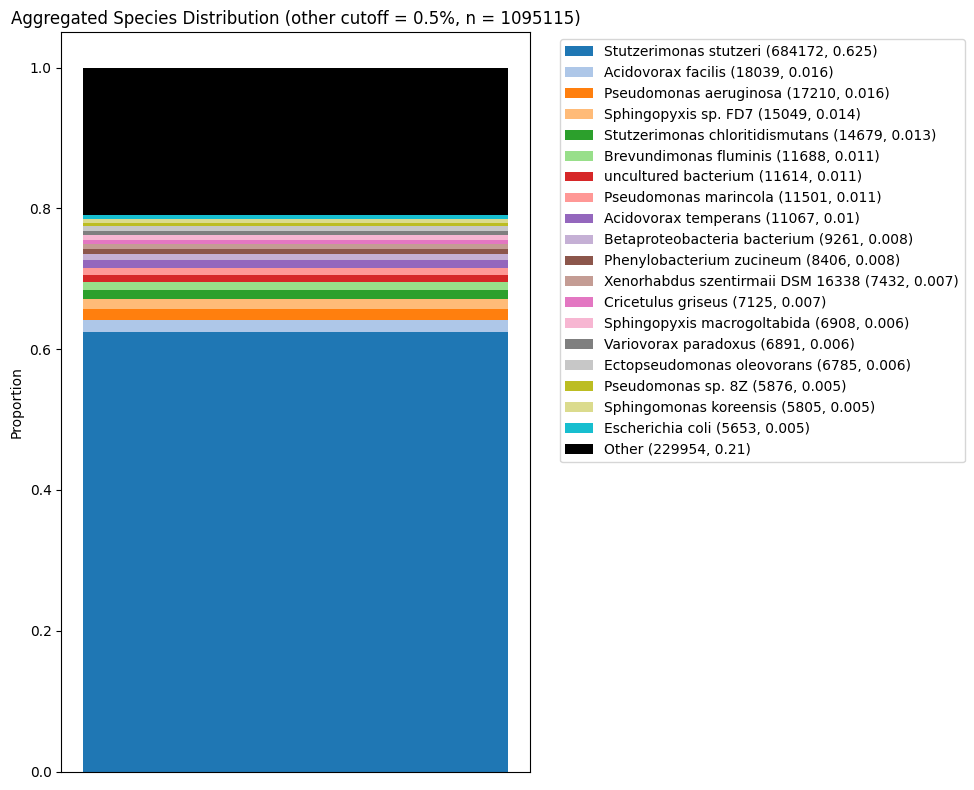

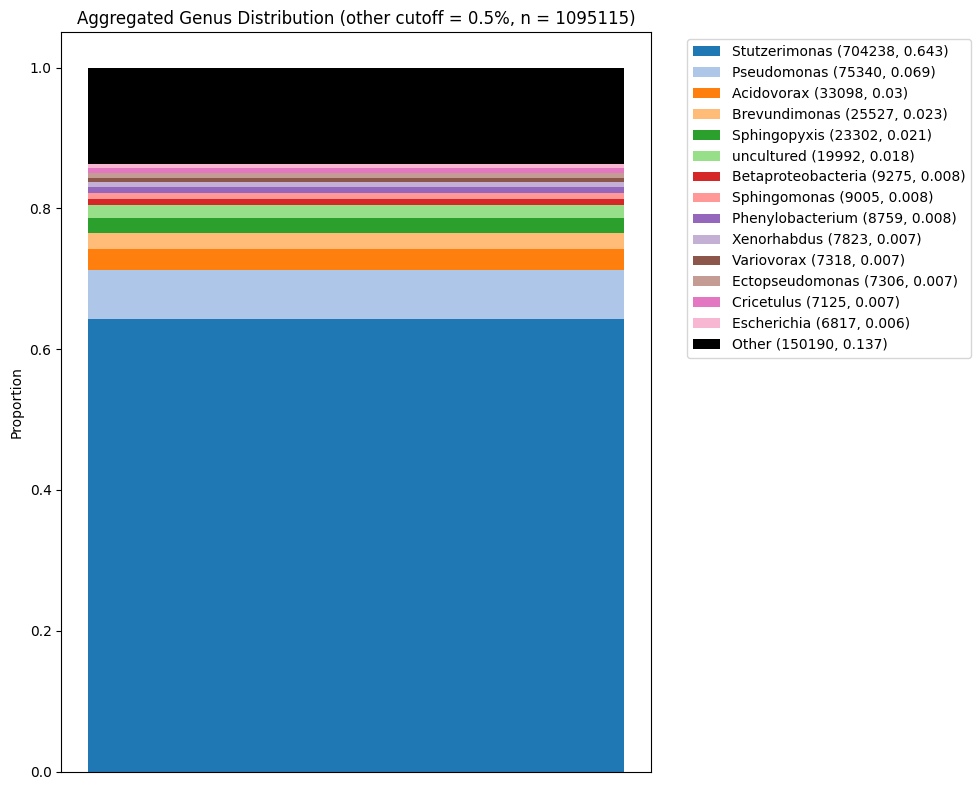

In [14]:
spct_df.dropna(inplace=True)
gnct_df = spct_df.groupby(lambda s: s.split(' ')[0] if isinstance(s, str) else 'Unknown').sum()

spct_df_copy = spct_df.reset_index().rename(columns={'index': 'name'}) if 'name' not in spct_df.columns else spct_df
gnct_df_copy = gnct_df.reset_index().rename(columns={'index': 'name'}) if 'name' not in gnct_df.columns else gnct_df

taxo_utils.create_stacked_bar_plot(spct_df_copy, 'Aggregated Species Distribution', cutoff=0.005, out_dir=r'figures\barplots')
taxo_utils.create_stacked_bar_plot(gnct_df_copy, 'Aggregated Genus Distribution', cutoff=0.005, out_dir=r'figures\barplots')


In [15]:
spct_df = spct_df.reset_index().rename(columns={'index': 'name'})
print(sum(spct_df['count']), 'total classified species')
spct_df.to_csv(r'data_output\agg_summary.tsv', sep='\t', index=False)

1095115 total classified species


In [16]:
# Create id to species mapping TSV

output_rows = []
for id, classifiers_for_id in id_to_cats.items():
    if len(classifiers_for_id) == 1:
        cat = next(iter(classifiers_for_id))
        species = id_species_mapping[cat][id]
        output_rows.append({'query_id': id, 'species_name': species})
    else:
        species_names = set(id_species_mapping[cat][id] for cat in classifiers_for_id)
        if len(species_names) == 1:
            species = next(iter(species_names))
            output_rows.append({'query_id': id, 'species_name': species})

species_hits_df = pd.DataFrame(output_rows)
species_hits_df.to_csv('data_output/species_id_mapping.tsv', sep = '\t')
print(f'Saved {len(species_hits_df)} mappings to data_output\\species_id_mapping.tsv')

Saved 1095115 mappings to data_output\species_id_mapping.tsv
